(238688, 30, 5)
(238688, 1)
(167081, 30, 5, 1)
(71607, 30, 5, 1)
[0. 0. 0. ... 0. 0. 0.]
{0: 0.8092657173302334, 1: 1.308366352915381}
(167081, 2)
(71607, 2)


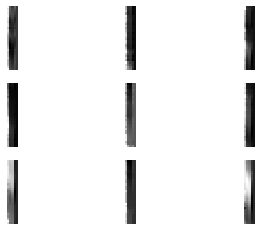

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 5, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 5, 64)         640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 5, 64)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 2, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 2, 128)        73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15, 2, 128)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 1, 128)         0   

 - 5s - loss: 0.3518 - accuracy: 0.8332 - val_loss: 0.3010 - val_accuracy: 0.8147

Epoch 00039: val_accuracy did not improve from 0.83328
Epoch 40/500
 - 5s - loss: 0.3514 - accuracy: 0.8327 - val_loss: 0.4023 - val_accuracy: 0.8244

Epoch 00040: val_accuracy did not improve from 0.83328
Epoch 41/500
 - 5s - loss: 0.3511 - accuracy: 0.8325 - val_loss: 0.3922 - val_accuracy: 0.8262

Epoch 00041: val_accuracy did not improve from 0.83328
Epoch 42/500
 - 5s - loss: 0.3506 - accuracy: 0.8329 - val_loss: 0.3246 - val_accuracy: 0.8302

Epoch 00042: val_accuracy did not improve from 0.83328
Epoch 43/500
 - 5s - loss: 0.3500 - accuracy: 0.8335 - val_loss: 0.2435 - val_accuracy: 0.8289

Epoch 00043: val_accuracy did not improve from 0.83328
Epoch 44/500
 - 5s - loss: 0.3492 - accuracy: 0.8341 - val_loss: 0.3093 - val_accuracy: 0.8223

Epoch 00044: val_accuracy did not improve from 0.83328
Epoch 45/500
 - 5s - loss: 0.3493 - accuracy: 0.8339 - val_loss: 0.3007 - val_accuracy: 0.8197

Epoch 00045

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline

input_data_length = 30
model_num = 85
num_classes = 2

Made_X = np.load('Made_X/Made_X %s_%s.npy' % (input_data_length, model_num))
Made_Y = np.load('Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num)).reshape(-1, 1)


#       dataset 분리      #
# dataX 구성 : VOLUME, MA, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
# dataX 구성 : VOLUME, EMA1, EMA2, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC, MACD_ZERO
Made_X = Made_X[:, :,[8, 9, 10, 11, 12]]
print(Made_X.shape)
print(Made_Y.shape)

row = Made_X.shape[1]
col = Made_X.shape[2]

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                   shuffle=False)

X_train = X_train.astype('float32').reshape(-1, input_data_length, col, 1)
X_val = X_val.astype('float32').reshape(-1, input_data_length, col, 1)
print(X_train.shape)
print(X_val.shape)

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 

# Data Class Weight
from sklearn.utils import class_weight

print(Y_train[:, 0])
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(Y_train[:, 0]),
                                                  Y_train[:, 0])
class_weights = dict(enumerate(class_weights))
# class_weights[1] *= 0.97
# class_weights[2] *= 0.97
print(class_weights)
# quit()

Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_val = np_utils.to_categorical(Y_val, num_classes)
print(Y_train.shape)
print(Y_val.shape)

datagen = ImageDataGenerator( 
#     rotation_range = 60,
#     zoom_range = 0.6,
#     shear_range = 0.6,
#     horizontal_flip = True,
#     width_shift_range=0.6,
#     height_shift_range=0.6,
    fill_mode = 'nearest'
    )

testgen = ImageDataGenerator( 
    )
datagen.fit(X_train)
batch_size = 128

for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(input_data_length, col), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break
    
    
train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 


from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(row, col, 1)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model

model = FER_Model()
# from keras.models import load_model
# model = load_model('model/rapid_ascending %s_%s_rsimacd.hdf5' % (input_data_length, model_num))
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="model/rapid_ascending %s_%s_rsimacd.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_accuracy', patience=100)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 500
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size,
                    shuffle=False)



In [ ]:
from keras.models import load_model

model = load_model('model/rapid_ascending %s_%s.hdf5' % (input_data_length, model_num))
# model = load_model('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.hdf5' % input_data_length)
# loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
# print("Test Loss " + str(loss[0]))
# print("Test Acc: " + str(loss[1]))

# loss = model.evaluate(X_val, Y_val) 
# print(X_val.shape)
# print(Y_val.shape)

# print("Val Loss " + str(loss[0]))
# print("Val Acc: " + str(loss[1]))

#     Prediction    #
Y_pred_ = model.predict(X_test, verbose=1)

# Y_pred = Y_pred_[:,[-1]]
# print(Y_pred.shape)
# print(Y_test.shape)
Y_pred = np.argmax(Y_pred_, axis=1)
t_te = np.argmax(Y_test, axis=1)

#     Manual processing     #
Y_pred_one = Y_pred_[:, [-1]]
print(Y_pred_)
max_value = np.max(Y_pred_one)
print(max_value)

limit_line = 0.9
Y_pred_one = np.where(Y_pred_one > max_value * limit_line, 1, 0)

# print(Y_pred_one)
Y_pred_one = Y_pred_one.reshape(-1,)
# print(Y_pred_1)
# print(Y_pred.shape)
# print(t_te.shape)

# fail = 0
# fail2 = 0
# for i in range(len(Y_pred)):
#   if Y_pred_1[i] != t_te[i]:
#     fail += 1

#   if Y_pred[i] != t_te[i]:
#     fail2 += 1

# print(1 - fail / len(Y_pred))
# print(1 - fail2 / len(Y_pred))

# print(np.sum(Y_pred), np.sum(t_te))
# print('Y_pred / Y_test :', np.sum(Y_pred) / np.sum(t_te))
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(100,10))
plt.subplot(211)
plt.plot(Y_test, 'purple', label='test')

plt.subplot(212)
plt.plot(Y_pred_one, 'y', label='pred')
plt.show()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.png' % input_data_length)
# plt.close()